In [3]:
# Run in Python 3.7 kernel
# Import libraries

import pandas as pd
import numpy as np # creating and manipulating arrays
import matplotlib.pyplot as plt # visualizing data
import sklearn # regression models
import statsmodels.api as sm 

1. Develop Linear Regression model using Statmodels

In [4]:
data = pd.read_csv("garments_worker_productivity.csv", header = 0) # read in data
data = pd.get_dummies(data, columns=["quarter","department","day","team"], drop_first=True) # create dummy variables for categorical data
data = data.dropna() # drop rows with NaN values
data = data.drop('date', axis=1) # drop dates
data_ols = sm.add_constant(data)
model = sm.OLS(endog= data_ols.actual_productivity, exog = data_ols.loc[:, data_ols.columns!='actual_productivity']) # use actual productivity as the dependent variable, and everything else as independent
results = model.fit()
print(results.summary())

# Compile Significant Variables
sigparams = results.params[results.pvalues < 0.05] # Get significant variables
sigparams = sigparams.to_frame() # Create a dataframe of them
sigparams.columns = ['coefficient'] # Name the columns
sigparams = sigparams['coefficient'].astype(float) # Convert to float so that you can sort it by absolute value
sigparams = sigparams.sort_values(key=abs, ascending=False) # Order by absolute value

data_new = np.array([[0],[1],[2],[3],[4],[5],[6]]) #you'll use this later

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.813
Model:                             OLS   Adj. R-squared:                  0.805
Method:                  Least Squares   F-statistic:                     99.37
Date:                 Sat, 24 Sep 2022   Prob (F-statistic):          3.90e-219
Time:                         23:38:18   Log-Likelihood:                 889.27
No. Observations:                  691   AIC:                            -1719.
Df Residuals:                      661   BIC:                            -1582.
Df Model:                           29                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
targeted_productivit

2. Select the best features using forward selection

In [5]:
# Show significant parameters
print(sigparams)

targeted_productivity    0.621713
department_sweing        0.145683
team_11                 -0.043256
idle_men                -0.006253
smv                     -0.003984
incentive                0.003253
no_of_workers            0.002039
idle_time                0.000614
over_time               -0.000003
Name: coefficient, dtype: float64


Test Models

In [6]:
il = [] #create blank list to assign features to
for x in range(0, (sigparams.count())):
    if x == 0:
        model = sm.OLS(endog= data_ols.actual_productivity, exog = data_ols.loc[:, data_ols.columns==sigparams.index[0]])
        results = model.fit()
        print(il)
        print(results.rsquared_adj)
        il.append(sigparams.index[0])
    else:
        il.append(sigparams.index[x])
        model = sm.OLS(endog= data_ols.actual_productivity, exog = data_ols[il])
        results = model.fit()
        print(il)
        print(results.rsquared_adj)




[]
0.9773934809944065
['targeted_productivity', 'department_sweing']
0.4864174278778667
['targeted_productivity', 'department_sweing', 'team_11']
0.4859171427117741
['targeted_productivity', 'department_sweing', 'team_11', 'idle_men']
0.5326273408778037
['targeted_productivity', 'department_sweing', 'team_11', 'idle_men', 'smv']
0.5530013010538016
['targeted_productivity', 'department_sweing', 'team_11', 'idle_men', 'smv', 'incentive']
0.792823221566805
['targeted_productivity', 'department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'no_of_workers']
0.7986647279602157
['targeted_productivity', 'department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'no_of_workers', 'idle_time']
0.8011087556246014
['targeted_productivity', 'department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'no_of_workers', 'idle_time', 'over_time']
0.8048791450397842


The model above with only targeted productivity in the model has an adjusted r-squared of 97.7%

However, since it is a target, not a metric, it isn't useful for predicting productivity, so we will remove it from the model.

In [7]:
sigparams = sigparams.drop('targeted_productivity')
print(sigparams)

department_sweing    0.145683
team_11             -0.043256
idle_men            -0.006253
smv                 -0.003984
incentive            0.003253
no_of_workers        0.002039
idle_time            0.000614
over_time           -0.000003
Name: coefficient, dtype: float64


Now we will re-run the analysis

In [8]:
il = []
for x in range(0, (sigparams.count())):
    if x == 0:
        model = sm.OLS(endog= data_ols.actual_productivity, exog = data_ols.loc[:, data_ols.columns==sigparams.index[0]])
        results = model.fit()
        print(il)
        print(results.rsquared_adj)
        il.append(sigparams.index[0])
    else:
        il.append(sigparams.index[x])
        model = sm.OLS(endog= data_ols.actual_productivity, exog = data_ols[il])
        results = model.fit()
        print(il)
        print(results.rsquared_adj)

[]
0.0
['department_sweing', 'team_11']
0.006763257386616206
['department_sweing', 'team_11', 'idle_men']
0.0733043559579889
['department_sweing', 'team_11', 'idle_men', 'smv']
0.10661507975692541
['department_sweing', 'team_11', 'idle_men', 'smv', 'incentive']
0.6693164460449099
['department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'no_of_workers']
0.6691637981027212
['department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'no_of_workers', 'idle_time']
0.6699514156001276
['department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'no_of_workers', 'idle_time', 'over_time']
0.6812456091514572


Every addition above increased the adjusted r squared value, except for no_of_workers.

Best features:
'department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'idle_time', 'over_time'

3. Compare the performance of OLS and SGD implementation of linear model

In [9]:
#final OLS model
model = sm.OLS(endog= data_ols.actual_productivity, exog = data_ols[['department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'idle_time', 'over_time']])
results = model.fit()
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.682
Model:                             OLS   Adj. R-squared:                  0.680
Method:                  Least Squares   F-statistic:                     245.1
Date:                 Sat, 24 Sep 2022   Prob (F-statistic):          1.09e-166
Time:                         23:38:18   Log-Likelihood:                 705.61
No. Observations:                  691   AIC:                            -1397.
Df Residuals:                      684   BIC:                            -1365.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
department_sweing     0.6141

In [10]:
data_new_ols = sm.add_constant(data_new)
print(data_new_ols)
ols_output = results.get_prediction(data_ols[['department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'idle_time', 'over_time']]).summary_frame(alpha=0.05)

ols_output_list = ols_output['mean'].tolist()
ols_output_list

[[1. 0.]
 [1. 1.]
 [1. 2.]
 [1. 3.]
 [1. 4.]
 [1. 5.]
 [1. 6.]]


[0.9548347158251089,
 0.7400002289892044,
 0.7912015501388202,
 0.774607407665501,
 0.6947070288548702,
 0.7203346901081642,
 0.69233637459345,
 0.7203346901081642,
 0.7159570875940315,
 0.7387778394178752,
 0.7912015501388202,
 0.5296653291556659,
 0.7456438462589571,
 0.7442753888269051,
 0.7447097951467438,
 0.8016186278304677,
 0.72013372771351,
 0.7713350488631259,
 0.7472382590244616,
 0.6947070288548702,
 0.7869314670733338,
 0.7370688586687788,
 0.4920327497742368,
 0.6984466775375011,
 0.7719337489896486,
 0.7884858202880698,
 0.7893037123757226,
 0.7250081320957855,
 0.7572757344313987,
 0.8016186278304677,
 0.7435911601108791,
 0.7719337489896486,
 0.6875765182682592,
 0.7370688586687788,
 0.6984466775375011,
 0.6046299346571532,
 0.8541498580000589,
 0.7468961446664486,
 0.6943649144968572,
 0.8016186278304677,
 0.719043732863286,
 0.7706508201471,
 0.7706508201471,
 0.7422227026788272,
 0.7422227026788272,
 0.7196504613921382,
 0.7370688586687788,
 0.6348477979423219,
 0.8

In [11]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [12]:
reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(data_ols[['department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'idle_time', 'over_time']], data_ols.actual_productivity)

y_pred = reg.predict(data_ols[['department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'idle_time', 'over_time']])
y_pred

array([0.9564315 , 0.74176384, 0.79190288, 0.77497551, 0.6945379 ,
       0.72030729, 0.69224094, 0.72030729, 0.71589992, 0.73900735,
       0.79190288, 0.52840749, 0.74578782, 0.74441037, 0.74487733,
       0.80217325, 0.72176364, 0.77190269, 0.74742644, 0.6945379 ,
       0.78748851, 0.73727847, 0.49052752, 0.6982704 , 0.77250533,
       0.78895111, 0.7897784 , 0.72504518, 0.75749617, 0.80217325,
       0.74372164, 0.77250533, 0.6888683 , 0.73727847, 0.6982704 ,
       0.60355084, 0.85506179, 0.74708207, 0.69419353, 0.80217325,
       0.72054737, 0.77121396, 0.77121396, 0.74234419, 0.74234419,
       0.71961857, 0.73727847, 0.63433082, 0.83474435, 0.83474435,
       0.72254329, 0.72254329, 0.74037538, 0.78206141, 0.674737  ,
       0.674737  , 0.73399395, 0.69947331, 0.66923959, 0.66724629,
       0.83474435, 0.83474435, 0.77169933, 0.77983921, 0.72254329,
       0.7813998 , 0.74037538, 0.77999523, 0.72762554, 0.80525039,
       0.69341554, 0.62394789, 0.89204027, 0.83474435, 0.83169

691
691
691


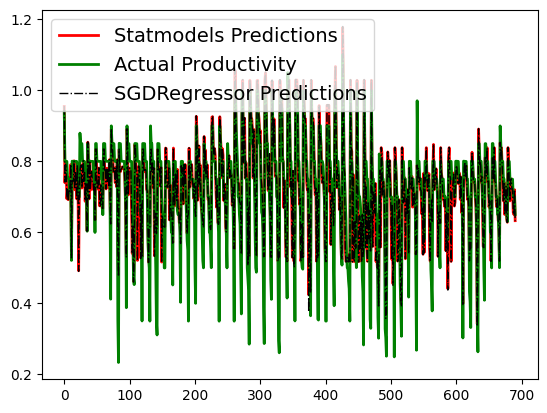

In [44]:
ap = data_ols['actual_productivity'].tolist()
print(len(ap))
print(len(ols_output_list))
print(len(y_pred))



plt.plot(ols_output_list, "r-", linewidth=2, label="Statmodels Predictions")
plt.plot(ap, "green", linewidth=2, label="Actual Productivity")
plt.plot(y_pred, "black", linestyle='dashdot',  linewidth=1, label="SGDRegressor Predictions")


plt.legend(loc="upper left", fontsize=14)
plt.show()

OLS MPE
10.907896573571593
SGD MPE
10.8791697643402


<function matplotlib.pyplot.show(close=None, block=None)>

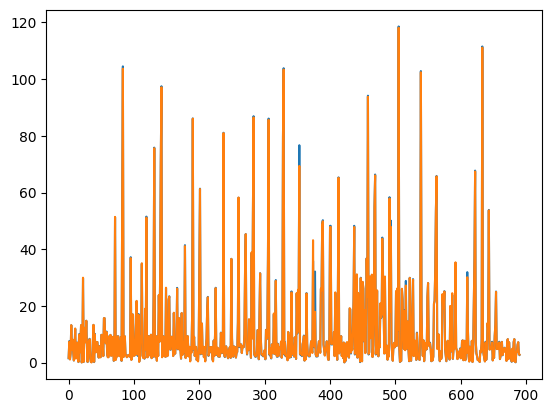

In [56]:
#create vectors to compute MPE
ap_vec = np.array(ap)
ols_vec = np.array(ols_output_list)
sgd_vec = np.array(y_pred)

ols_pe = abs(((ols_vec - ap_vec) / ap_vec) * 100)
sgd_pe = abs(((sgd_vec - ap_vec) / ap_vec) * 100)

ols_mpe = np.mean(ols_pe)
sgd_mpe = np.mean(sgd_pe)

print("OLS MPE")
print(ols_mpe)
print("SGD MPE")
print(sgd_mpe)

plt.plot(ols_pe)
plt.plot(sgd_pe)
plt.show

In this case, the difference in error between the 2 methods is tiny. ~0.03%. OLS does have the advantage, however.

4. Polynomial Regression Model

In [57]:
# Import libraries

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [60]:
y = data_ols.actual_productivity
X = data_ols.drop('actual_productivity',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = .2, random_state = 42)

In [62]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)
X_val_poly = poly_features.fit_transform(X_val)

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X_train_poly, y_train.ravel())
poly_train_pred = sgd_reg.predict(X_train_poly)
poly_test_pred = sgd_reg.predict(X_test_poly)
poly_val_pred = sgd_reg.predict(X_val_poly)

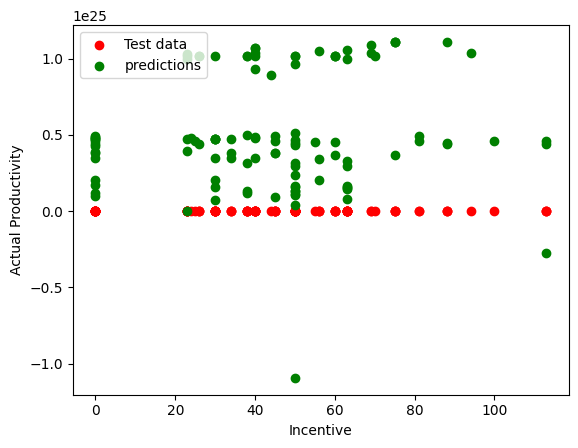

In [64]:
plt.scatter(X_test['incentive'], y_test, color = "red", label = "Test data")
plt.scatter(X_test['incentive'], poly_test_pred, color = "green", label = "predictions")
plt.xlabel("Incentive")
plt.ylabel("Actual Productivity")
plt.legend(loc="upper left")
plt.show()

In [65]:
val_error = mean_squared_error(y_val, poly_val_pred)
train_error = mean_squared_error(y_train, poly_train_pred)

print("Training MSE: ", train_error)
print("Validation MSE: ", val_error)

score = sgd_reg.score(X_train_poly, y_train)
print("R-squared:", score)

Training MSE:  4.290449000388457e+49
Validation MSE:  4.841085170004872e+49
R-squared: -1.737866666298804e+51


This model is a terrible fit

In [72]:
poly_params = {
    'eta0':[0.0001,0.001,0.01,0.1,1]
    }

poly_clf = GridSearchCV(SGDRegressor(max_iter=1000, tol=1e-3, random_state=42, learning_rate='constant'), poly_params, n_jobs=-1, scoring='f1', error_score=0)
poly_clf = poly_clf.fit(X_train, y_train)

y_pred_poly = poly_clf.predict(X_test)

poly_clf.best_estimator_

SGDRegressor(eta0=0.0001, learning_rate='constant', random_state=42)

The best learning rate for the polynomial model is .0001

In [75]:
reg_params = {
    'eta0':[0.0001,0.001,0.01,0.1,1]
}
reg = GridSearchCV(SGDRegressor(max_iter=1000, tol=1e-3), reg_params, n_jobs=-1, scoring='f1', error_score=0)
reg_clf = reg.fit(data_ols[['department_sweing', 'team_11', 'idle_men', 'smv', 'incentive', 'idle_time', 'over_time']], data_ols.actual_productivity)

reg_clf.best_estimator_

SGDRegressor(eta0=0.0001)

The best learning rate for the linear regression model is also .0001

5. Lasso Regression

In [79]:
lasso = make_pipeline(StandardScaler(), SGDRegressor(alpha=0.0001, epsilon=0.01, eta0=0.1, penalty="l1", max_iter=1000, tol=1e-3, random_state=42))
lasso.fit(X_train, y_train)
lasso_train_pred = lasso.predict(X_train)
lasso_test_pred = lasso.predict(X_test)
lasso_val_pred = lasso.predict(X_val)

val_error = mean_squared_error(y_val, lasso_val_pred)
train_error = mean_squared_error(y_train, lasso_train_pred)

# Get validation scores
scores = cross_validate(lasso, X_train, y_train, cv=3)

print("Training MSE: ", train_error)
print("Validation MSE: ", np.mean(scores['test_score']))

score = lasso.score(X_test, y_test)
print("R-squared:", score)

Training MSE:  0.007758334773934884
Validation MSE:  -29023.409675419945
R-squared: 0.7465595824870592


In [88]:
lasso = make_pipeline(StandardScaler(), SGDRegressor(alpha=0.0001, epsilon=0.01, eta0=0.1, penalty="l1", max_iter=1000, tol=1e-3, early_stopping=True, random_state=42))
lasso.fit(X_train, y_train)
lasso_train_pred = lasso.predict(X_train)
lasso_test_pred = lasso.predict(X_test)
lasso_val_pred = lasso.predict(X_val)

val_error = mean_squared_error(y_val, lasso_val_pred)
train_error = mean_squared_error(y_train, lasso_train_pred)

# Get validation scores
scores = cross_validate(lasso, X_train, y_train, cv=3)

print("Training MSE: ", train_error)
print("Validation MSE: ", np.mean(scores['test_score']))

score = lasso.score(X_test, y_test)
print("R-squared:", score)

Training MSE:  0.0055531872978053344
Validation MSE:  -156220.79645457273
R-squared: 0.7446182498153986


Early stopping didn't make much of a difference to the r-squared values, but dramatically reduced the MSE for both training and validation data

6. Ridge Regression

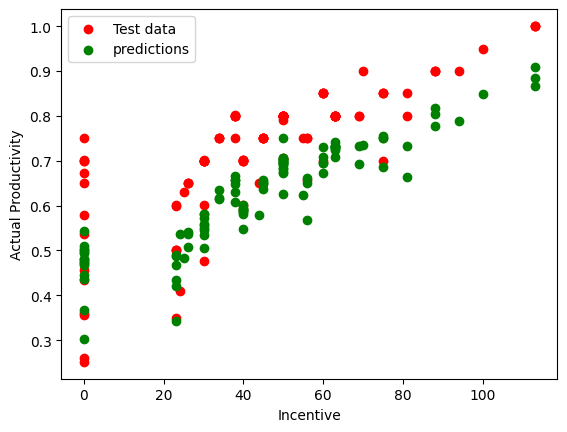

c:\Users\Qthooloo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Qthooloo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\Qthooloo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\Qthooloo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\Qthooloo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\pipeline.py", line 711, in score
    return s

Training MSE:  0.01470355610959784
Validation MSE:  nan


c:\Users\Qthooloo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Qthooloo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\Qthooloo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\Qthooloo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "c:\Users\Qthooloo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\pipeline.py", line 711, in score
    return s

ValueError: continuous is not supported

In [118]:
ridge_params = {
    'learning_rate':['constant','optimal','invscaling','adaptive'],
    'eta0':[0.0001,0.001,0.01,0.1,1],
    'loss':['squared_error','huber','epsilon_insensitive','squared_epsilon_insensitive']    
    }
ridge_clf = GridSearchCV(SGDRegressor(alpha=0.0001, epsilon=0.01, penalty="l2", max_iter=1000, tol=1e-3, random_state=42), ridge_params, n_jobs=-1, scoring='f1', error_score=0)
ridge_clf = ridge_clf.fit(X_train, y_train)

ridge = make_pipeline(StandardScaler(), ridge_clf)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

plt.scatter(X_test['incentive'], y_test, color = "red", label = "Test data")
plt.scatter(X_test['incentive'], y_pred, color = "green", label = "predictions")
plt.xlabel("Incentive")
plt.ylabel("Actual Productivity")
plt.legend(loc="upper left")
plt.show()

ridge_train_pred = ridge.predict(X_train)
ridge_test_pred = ridge.predict(X_test)
ridge_val_pred = ridge.predict(X_val)
val_error = mean_squared_error(y_val, ridge_val_pred)
train_error = mean_squared_error(y_train, ridge_train_pred)
# Get validation scores
scores = cross_validate(ridge, X_train, y_train, cv=3)
print("Training MSE: ", train_error)
print("Validation MSE: ", np.mean(scores['test_score']))
score = ridge.score(X_test, y_test)
print("R-squared:", score)


7. ElasticNet Regression

In [124]:
enet_params = {
    'learning_rate':['constant','optimal','invscaling','adaptive'],
    'eta0':[0.0001,0.001,0.01,0.1,1],
    'loss':['squared_error','huber','epsilon_insensitive','squared_epsilon_insensitive']    
    }
enet_clf = GridSearchCV(SGDRegressor(alpha=0.0001, epsilon=0.01, penalty="elasticnet", max_iter=1000, tol=1e-3, random_state=42), enet_params, n_jobs=-1, scoring='f1', error_score=0)
enet_clf = enet_clf.fit(X_train, y_train)

elasticnet_train_pred = enet_clf.predict(X_train)
elasticnet_test_pred = enet_clf.predict(X_test)
elasticnet_val_pred = enet_clf.predict(X_val)

val_error = mean_squared_error(y_val, elasticnet_val_pred)
train_error = mean_squared_error(y_train, elasticnet_train_pred)
# Get validation scores
scores = cross_validate(enet_clf, X_train, y_train, cv=3)
print("Training MSE: ", train_error)
print("Validation MSE: ", np.mean(scores['test_score']))

score = elasticnet.score(X_test, y_test)
print("R-squared:", score)

enet = make_pipeline(StandardScaler(), enet_clf)
enet.fit(X_train, y_train)
y_pred = enet.predict(X_test)

plt.scatter(X_test['incentive'], y_test, color = "red", label = "Test data")
plt.scatter(X_test['incentive'], y_pred, color = "green", label = "predictions")
plt.xlabel("Incentive")
plt.ylabel("Actual Productivity")
plt.legend(loc="upper left")
plt.show()


c:\Users\Qthooloo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Qthooloo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\Qthooloo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\Qthooloo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_search.py", line 473, in score
    score = self.scorer_(self.best_estimator_, X, y)
  File "c:\Users\Qthooloo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sam

Training MSE:  6.049118500750452e+30
Validation MSE:  nan


c:\Users\Qthooloo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Qthooloo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\Qthooloo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "c:\Users\Qthooloo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_search.py", line 473, in score
    score = self.scorer_(self.best_estimator_, X, y)
  File "c:\Users\Qthooloo\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_scorer.py", line 221, in __call__
    sample_weight=sam

NameError: name 'elasticnet' is not defined